In [28]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random

# Funkcija za izvuci ravnotezni položj njihala
def ravnotezniPolozaj(x,y):

    # kopiram liste da ne diram originale
    sx = x.copy()
    sy = y.copy()

    # uzmem 10 max x-eva s live i desne strane i uprosječim ih, pa na polovištu leži xrp
    sx.sort()    
    tmpx1 = [sx[i] for i in range(10)]
    tmpx2 = [sx[-i] for i in range(1,11,1)]
    tmpx1 = sum(tmpx1) / len(tmpx1)
    tmpx2 = sum(tmpx2) / len(tmpx2)
    xrp = 0.5*(tmpx1+tmpx2)

    # isti postupak sa y-ima samo uzmem max-eve 
    sy.sort()
    yrp = [sx[-i] for i in range(1,11,1)]
    yrp = sum(yrp) / len(yrp)

    return xrp,yrp


#   funkcija za traženje centra kružnice preko tri ne kolinearne točke koje opisuju kružnicu
def centar(x1, y1, x2, y2, x3, y3):

    A = (x1 ** 2 + y1 ** 2) * (y2 - y3) + (x2 ** 2 + y2 ** 2) * (y3 - y1) + (x3 ** 2 + y3 ** 2) * (y1 - y2)
    B = (x1 ** 2 + y1 ** 2) * (x3 - x2) + (x2 ** 2 + y2 ** 2) * (x1 - x3) + (x3 ** 2 + y3 ** 2) * (x2 - x1)
    C = 2 * (x1 * (y2 - y3) - y1 * (x2 - x3) + x2 * y3 - y2 * x3)
    D = (x1 ** 2 + y1 ** 2) * (x2 * y3 - y2 * x3) + (x2 ** 2 + y2 ** 2) * (x3 * y1 - y3 * x1) + (x3 ** 2 + y3 ** 2) * (x1 * y2 - y1 * x2)
    E = (x1 * (y2 - y3) - y1 * (x2 - x3)) * (x2 * y3 - y2 * x3) + (x2 * (y3 - y1) - y2 * (x3 - x1)) * (x3 * y1 - y3 * x1) + (x3 * (y1 - y2) - y3 * (x1 - x2)) * (x1 * y2 - y1 * x2)
    F = (x1 * (y2 - y3) - y1 * (x2 - x3)) ** 2 + (x2 * (y3 - y1) - y2 * (x3 - x1)) ** 2 + (x3 * (y1 - y2) - y3 * (x1 - x2)) ** 2
    
    h = (D + E) / (2 * F)
    k = (A + B) / (2 * C)
    
    return h, k

# funk za koja bira tri rand točke i provjeri jesu li kolinearne ako nisu onda ih return-a
def randNCL(points):

    # randomiziramo točke 
    random.shuffle(points)
    
    # vrtimo for dok ne nađemo dobre točke 
    for i in range(len(points)-2):
        x1, y1 = points[i]
        x2, y2 = points[i+1]
        x3, y3 = points[i+2]
        
        # preko determinante provjerimo da nisu kolinearne
        det = x1*(y2-y3) - y1*(x2-x3) + x2*y3 - y2*x3
        if det != 0:
            return x1, y1, x2, y2, x3, y3 

    return None

Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
[(1144.5, 782.5), (1144.0, 785.0), (1144.0, 781.0), (1144.0, 772.0), (1144.0, 758.0), (1144.0, 741.0), (1144.0, 720.0), (1143.5, 699.5), (1143.5, 679.5), (1142.0, 662.0), (1140.5, 649.5), (1139.0, 643.0), (1138.0, 642.5), (1137.0, 646.0), (1136.5, 657.5), (1136.0, 674.5), (1135.5, 693.5), (1136.0, 715.0), (1136.0, 736.0), (1136.5, 755.5), (1139.0, 771.5), (1140.0, 781.0), (1141.0, 786.5), (1141.0, 785.5), (1143.0, 777.5), (1143.5, 763.5), (1145.0, 746.5), (1146.5, 725.5), (1145.5, 704.5), (1147.0, 684.0), (1146.0, 667.0), (1145.0, 653.0), (1145.0, 645.0), (1144.5, 642.5), (1143.5, 645.5), (1142.5, 655.5), (1141.0, 669.0), (1140.5, 686.5), (1136.0, 707.0), (1136.0, 727.0), (1135.5, 746.5), (1136.0, 762.5), (1136.5, 773.5), (1136.5, 780.5), (1136.5, 781.5), (1136.5, 775.5), (1138.0, 765.5), (1138.5, 749.5), (1140.0, 729.5), (1141.0, 710.0), (1143.0, 689.0), (1143.5, 670.5), (1144.0, 655.

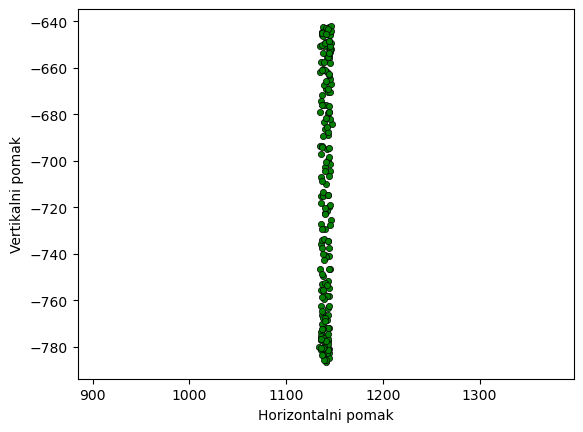

In [75]:
cap = cv2.VideoCapture('masafs.mp4')

tracker = cv2.TrackerCSRT_create()
# read-amo prvi frame i označimo masu
ret, frame = cap.read()
bbox = cv2.selectROI(frame, False)
tracker.init(frame, bbox)

positions = []

# provrtimo cijeli video
while True:

    ret, frame = cap.read()

    # break kad nestane frame-ova
    if not ret:
        break
    # update-amo tracker u novom frame-u
    ok, bbox = tracker.update(frame)
    
    # ako smo uspješno update-ali tracker izvadimo poziciju iz njega
    if ok:
        x, y, w, h = [int(i) for i in bbox]
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        position = (x + w/2, y + h/2)  # centar tracking box-a
        positions.append(position)
    
    cv2.imshow('frame', frame)
    
    # q za break
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

print(positions)

graphx=[]
graphy=[]
for i in range(len(positions)):
    graphx.append(positions[i][0])
    graphy.append(-positions[i][1])

plt.scatter(graphx, graphy, s=20, color='green', edgecolor='black', linewidth=0.5)  # Adjust 's' for dot size and 'color' for dot color
plt.xlim(min(graphx) - 250, max(graphx) + 250)
plt.xlabel("Horizontalni pomak")
plt.ylabel("Vertikalni pomak")
plt.show()

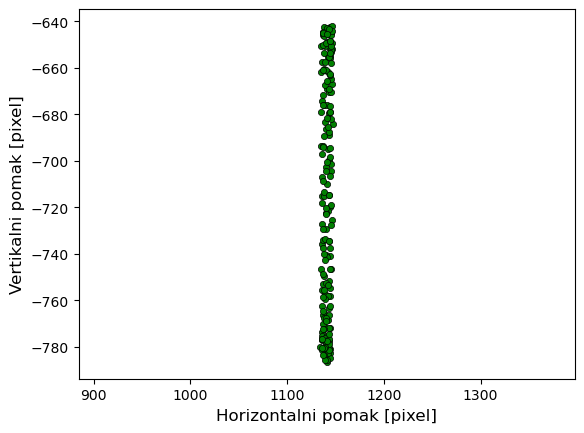

In [76]:
plt.scatter(graphx, graphy, s=20, color='green', edgecolor='black', linewidth=0.5)

# Set the x and y axis labels with units using LaTeX formatting and larger font size
plt.xlim(min(graphx) - 250, max(graphx) + 250)
plt.xlabel("Horizontalni pomak [pixel]", fontsize=12)  # Adjust the fontsize as needed
plt.ylabel("Vertikalni pomak [pixel]", fontsize=12)    # Adjust the fontsize as needed

# Show the plot
plt.show()

In [77]:
cap = cv2.VideoCapture('masafs.mp4')

if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

timestamps = []  

while True:
    ret, frame = cap.read()

    if not ret:
        break  

    timestamp = cap.get(cv2.CAP_PROP_POS_MSEC) / 1000.0  # Convert to seconds
    timestamps.append(timestamp)

timestamps.pop()
cap.release()

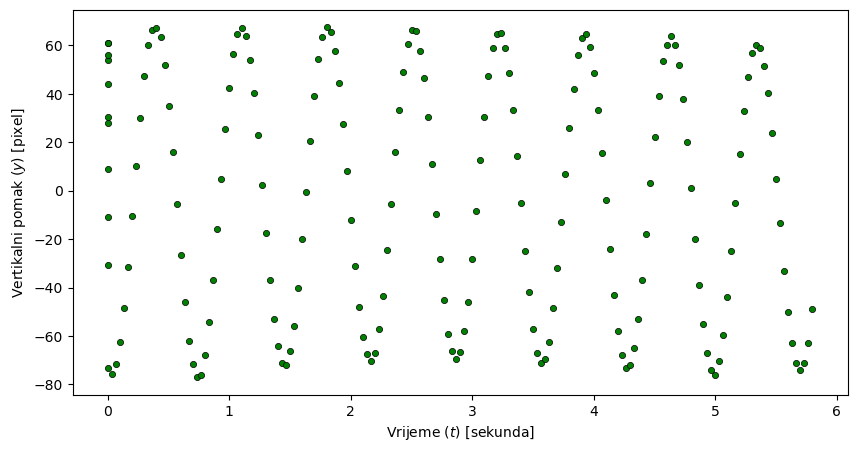

In [78]:
gy=[]
for i in range(len(graphy)):
    gy.append(graphy[i] + 709.5) 

plt.figure(figsize=(10, 5))  
plt.scatter(timestamps, gy, s=20, color='green', edgecolor='black', linewidth=0.5)  
plt.xlabel("Vrijeme ($t$) [sekunda]")
plt.ylabel("Vertikalni pomak ($y$) [pixel]")
plt.show()

In [7]:
import sys; sys.path.append('../')
from PDE_FIND_CM import *

def trim(u, d): #funkcija koja treba kasnije kako bi algoritam funkcionirao
    ind = np.arange(0, len(u))
    u_trim = np.delete(u, np.concatenate((ind[:d],ind[-d:])))
    return u_trim

    
gy=[]
for i in range(len(graphy)):
    gy.append(graphy[i] + 709) 
t=0

m = 1
n = len(positions)

u = [gy]
u = np.array(u)
t = np.array(timestamps)
dt = t[1]-t[0]

un = u
ut = np.zeros((m,n), dtype=np.complex64)
utt = np.zeros((m,n), dtype=np.complex64)

for i in range(m):
    ut[i,:] = FiniteDiff(u[i,:], dt, 1)
    utt[i,:] = FiniteDiff(u[i,:], dt,2) # koristi se kasnije kod funkcije TrainSTRidge

ut = np.reshape(ut, (n*m,1), order='F')
utt = np.reshape(utt, (n*m,1), order='F')

X_ders = np.hstack([np.ones((n*m,1)),ut])
X_data = np.hstack([np.reshape(u, (n*m,1), order='F')])
derivatives_description = ['','u_t']

X, descr = build_Theta(X_data, X_ders, derivatives_description, P=2, data_description = ['u'])
descr

w = TrainSTRidge(X,utt,100,10)
print("PDJ dobivena pomoću STRidge:")
print_pde(w, descr)



PDJ dobivena pomoću STRidge:
u_tt = (-0.629048 +0.000000i)u_t
    + (-65.138656 +0.000000i)u
    + (0.006285 +0.000000i)u^2
   


Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!


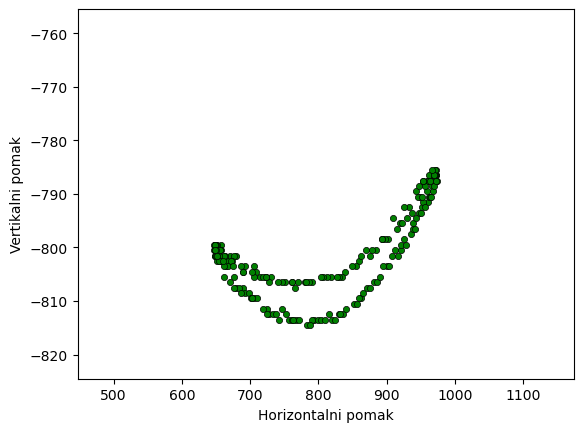

In [95]:
# load-amo video
cap = cv2.VideoCapture('fsmat.webm')

tracker = cv2.TrackerCSRT_create()
times = []
# read-amo prvi frame i označimo masu
ret, frame = cap.read()
bbox = cv2.selectROI(frame, False)
tracker.init(frame, bbox)

positions = []

# provrtimo cijeli video
while True:

    ret, frame = cap.read()

    # break kad nestane frame-ova
    if not ret:
        break

    # update-amo tracker u novom frame-u
    ok, bbox = tracker.update(frame)
    
    # ako smo uspješno update-ali tracker izvadimo poziciju iz njega
    if ok:
        x, y, w, h = [int(i) for i in bbox]
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        position = (x + w/2, y + h/2)  # centar tracking box-a
        positions.append(position)
    
    cv2.imshow('frame', frame)
    
    # q za break
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

graphx=[]
graphy=[]
for i in range(len(positions)):
    graphx.append(positions[i][0])
    graphy.append(-positions[i][1])

plt.scatter(graphx, graphy, s=20, color='green', edgecolor='black', linewidth=0.5)  
plt.xlabel("Horizontalni pomak")
plt.ylabel("Vertikalni pomak")
plt.ylim(min(graphy) - 10, max(graphy) + 30)
plt.xlim(min(graphx) - 200, max(graphx) + 200)
plt.show()

In [96]:
# Open the video file
cap = cv2.VideoCapture('fsmat.webm')

if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

timestamps = []  

while True:
    ret, frame = cap.read()

    if not ret:
        break  
    timestamp = cap.get(cv2.CAP_PROP_POS_MSEC) / 1000.0  # Convert to seconds
    timestamps.append(timestamp)

timestamps.pop()
cap.release()

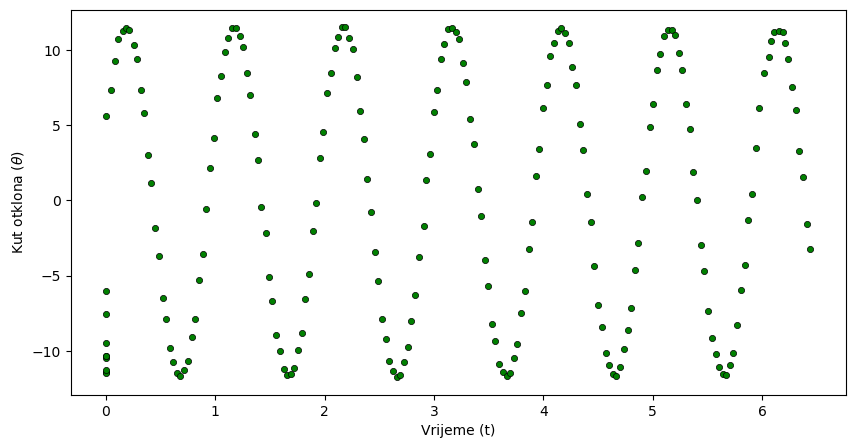

In [97]:
# izvučemo točke za odrediti uporište njihala
x1, y1, x2, y2, x3, y3 = randNCL(positions)

# izračunamo poziciju uporišta
h,k = centar(x1, y1, x2, y2, x3, y3)

# izračunamo ravnotežni položaj
ref_x,ref_y = ravnotezniPolozaj(graphx,graphy)

# računamo kut za svaki okvir
theta = []
for x, y in zip(graphx, graphy):
    # x i y pomak od ravnotežnog položaja
    dx = x - ref_x
    dy = (-y) - h

    # koristimo arctg kako bi dobili thetu 
    angle = np.arctan2(dy, dx)
    angle_degrees = np.degrees(angle)
    theta.append(angle_degrees)

# transformacije polja za potrebe crtanja grafa
frames = [i for i in range(len(theta))]
thetacp = theta.copy()
for i in range(len(thetacp)):
    thetacp[i] -=90


plt.figure(figsize=(10, 5))  
plt.scatter(timestamps, thetacp, s=20, color='green', edgecolor='black', linewidth=0.5)
plt.xlabel("Vrijeme (t)")
plt.ylabel("Kut otklona ($\\theta$)")
plt.show()


In [107]:
import sys; sys.path.append('../')
from PDE_FIND_CM import *

def trim(u, d): #funkcija koja treba kasnije kako bi algoritam funkcionirao
    ind = np.arange(0, len(u))
    u_trim = np.delete(u, np.concatenate((ind[:d],ind[-d:])))
    return u_trim


m = 1
n = len(positions)

podatci = []
run = 10
width = 5 # sirina prozora kod PolyDiff funkcije

temp = thetacp
temp = np.copy(thetacp) 
for i in range(len(temp)):
    temp[i] = temp[i] + 0.3

u = [temp]
u = np.array(u)
t = np.array(timestamps)

un = u
unt = np.zeros((m,n-2*width), dtype=np.complex64)
untt = np.zeros((m,n-2*width), dtype=np.complex64)
ones = np.ones((m,n), dtype=np.complex64)

for i in range(m):
    unt[i,:] = PolyDiff(un[i,:], t, diff=2, width=width)[:,0]
    untt[i,:] = PolyDiff(un[i,:], t, diff=2, width=width)[:,1] # koristi se kasnije kod funkcije TrainSTRidge

un = trim(un[0,:], width)
ones = trim(ones[0,:], width)

unt = np.reshape(unt, (-1,1), order='F')
untt = np.reshape(untt, (-1,1), order='F')

X_ders = np.hstack([np.ones((n*m-2*width,1)), unt])
X_data = np.hstack([np.reshape(un, (-1,1), order='F'),])
derivatives_description = ['','u_t']

X, descr = build_Theta(X_data, X_ders, derivatives_description, P=2, data_description = ['u'])

w = TrainSTRidge(X,untt,100,10)
podatci.append(w)

for i in range(len(podatci)):
    print("PDJ dobivena pomoću STRidge:")
    print_pde(podatci[i], descr)



PDJ dobivena pomoću STRidge:
u_tt = (-32.978022 +0.000000i)u
   
